In [5]:
import torch
from model import UNet
from dataset import RetinaDataset
from utils import load_data
import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as A
import warnings

warnings.filterwarnings("ignore")

EXP_ID = 18808

MODEL_PATH = f"/scratch/y.aboelwafa/Retina/Retina_Blood_Vessel_Segmentation/checkpoints/pytorch_{EXP_ID}.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(3, 1)
model.to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device("cpu")))

<All keys matched successfully>

In [6]:
show_imgs = 1
test_transform = A.Compose(
    [
        A.Resize(512, 512),
    ]
)
train_images, train_masks, test_images, test_masks = load_data("dataset")
test_dataset = RetinaDataset(test_images, test_masks, transform=test_transform)

In [14]:
def connected_components(img, min_threshold=0.3, max_threshold=0.5):

    _, sure_edges = cv2.threshold(img, max_threshold, 1, cv2.THRESH_BINARY)

    _, eliminated_edges = cv2.threshold(img, min_threshold, 1, cv2.THRESH_BINARY_INV)

    uncertain_edges = np.logical_and(img > min_threshold, img < max_threshold).astype(
        np.uint8
    )

    num_labels, labels = cv2.connectedComponents(
        uncertain_edges.astype(np.uint8), connectivity=8
    )

    return num_labels, labels

Number of components =  2776


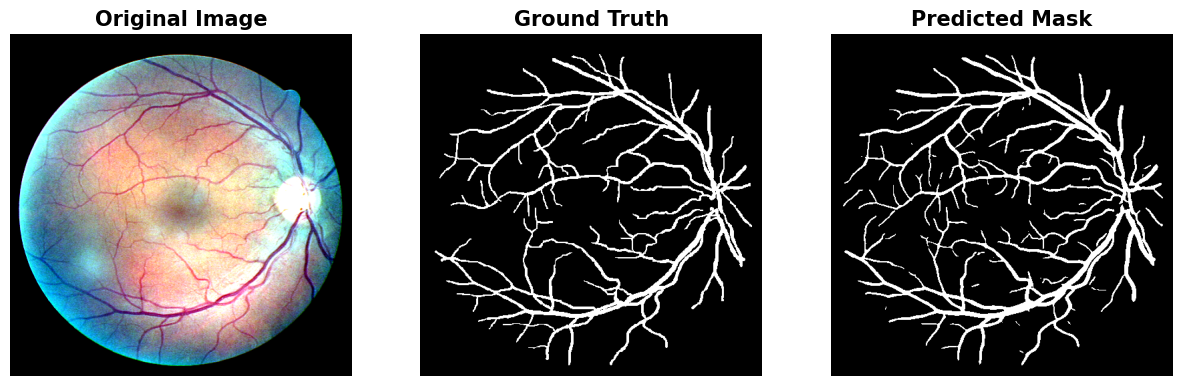

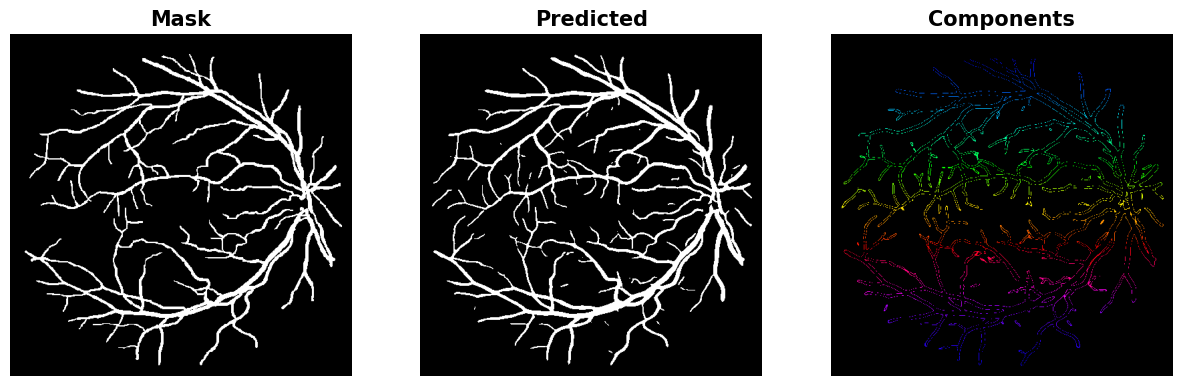

In [15]:
random_list = np.random.choice(len(test_dataset), show_imgs, replace=False)
for i in range(show_imgs):
    img, mask = test_dataset[random_list[i]]
    img = img.unsqueeze(0).to(device)
    mask = mask.unsqueeze(0).to(device)
    pred = model(img)
    pred = torch.sigmoid(pred)

    img = img.squeeze().permute(1, 2, 0).numpy()
    mask = mask.squeeze().numpy()
    pred = pred.squeeze().detach().numpy()
    num, components = connected_components(pred)
    print("Number of components = ", num)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    pred = pred > 0.5

    ax[0].imshow(img)
    ax[0].set_title("Original Image", fontsize=15, weight="bold")
    ax[0].axis("off")

    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title("Ground Truth", fontsize=15, weight="bold")
    ax[1].axis("off")

    ax[2].imshow(pred, cmap="gray")
    ax[2].set_title("Predicted Mask", fontsize=15, weight="bold")
    ax[2].axis("off")

    plt.show()

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(mask, cmap="gray")
    ax[0].set_title("Mask", fontsize=15, weight="bold")
    ax[0].axis("off")

    ax[1].imshow(pred > 0.5, cmap="gray")
    ax[1].set_title("Predicted", fontsize=15, weight="bold")
    ax[1].axis("off")

    label_hue = np.uint8(179 * components / np.max(components))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])  # type: ignore
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue == 0] = 0

    ax[2].imshow(labeled_img)
    ax[2].set_title("Components", fontsize=15, weight="bold")
    ax[2].axis("off")

    plt.show()